Hemer Jan, Pavlovský Jakub
# Prove of concept
---
This code serves as a proof of feasibility of the project. We have succesfully managed to scrape data from the *www.fortunaliga.cz* webiste for 2022/23 football season. this is not the whole dataset as multiple other seasons will be also scraped and merged to the dataset, using a similar method.

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sklearn 
import sklearn.datasets
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import lightgbm

#If you don't have these packages installed, please install it, otherwise it won't work

In [3]:
list_number1 = ['150', '0', '50', '50', '150', '200', '250']
list_number2 = ['0', '50', '100', '150', '200', '250', '300']
col_names = ['Zápas', 'G', 'G1p', 'G2p', 'ÚT', 'GR', 'S', 'SnB', 'P', 'P%', 'ŽK', 'ČK', 'F']
merged_df = pd.DataFrame(columns = col_names)

for yea in range(2014, 2025):
    for ln1, ln2 in zip(list_number1, list_number2):
        response = requests.get(f"https://www.fortunaliga.cz/statistiky?unit=4&status=&parameter=1&season={yea}&club=0&game_limit=&nationality=&age=&position=&list_number={ln1}&order=2&order_dir=1&list_number={ln2}")
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            table = soup.find('table', class_ = 'table')
        
            titles = soup.find_all('abbr')
            titles = [element.text for element in titles]

            content = table.find_all('tr')
            #print(type(content))
            content = [table.find_all('td') for element in content]
            content = [str(element.text) for result_set in content for element in result_set]
            #print(type(content))

            num_elements_per_row = 14
            num_rows = len(content) // num_elements_per_row
            rows = [content[i:i + num_elements_per_row] for i in range(0, len(content), num_elements_per_row)]
            df = pd.DataFrame(rows, columns = [f'Column_{i+1}' for i in range(num_elements_per_row)])
            df = df.set_index('Column_1')
            df.columns = titles
            df = df.reset_index()
            df = df.drop_duplicates(subset = ['Column_1'])

            merged_df = pd.concat([merged_df, df], axis = 0, ignore_index = True)

In [4]:
merged_df.head()

,Zápas,G,G1p,G2p,ÚT,GR,S,SnB,P,P%,ŽK,ČK,F,Column_1
0,"FKJ-BRN 0:0, 13/14",0,0,0,163,0,23,6,862,"75,2%",5,1,28,1.
1,"ZNO-TEP 0:0, 13/14",0,0,0,168,0,27,5,957,"76,1%",5,0,31,2.
2,"PLZ-ACS 0:0, 13/14",0,0,0,183,0,21,4,891,"78,6%",4,0,30,3.
3,"PLZ-DUK 0:0, 13/14",0,0,0,160,0,28,8,962,"78,2%",2,0,23,4.
4,"BOH-JIH 0:0, 13/14",0,0,0,185,0,25,8,901,"80,9%",4,0,26,5.


In [5]:
extracted_columns = merged_df['Zápas'].str.extract(r'([A-Z]+)-([A-Z]+) (\d+):(\d+), (\d{2}/\d{2})')
extracted_columns.columns = ['Home', 'Away', 'Home_Goals', 'Away_Goals', 'Season']
extracted_columns['Match'] = extracted_columns['Home'] + '-' + extracted_columns['Away']
extracted_columns.head(1)

,Home,Away,Home_Goals,Away_Goals,Season,Match
0,FKJ,BRN,0,0,13/14,FKJ-BRN


In [6]:
final_df = pd.concat([extracted_columns, merged_df.drop('Zápas', axis=1)], axis=1)
final_df.head()

,Home,Away,Home_Goals,Away_Goals,Season,Match,G,G1p,G2p,ÚT,GR,S,SnB,P,P%,ŽK,ČK,F,Column_1
0,FKJ,BRN,0,0,13/14,FKJ-BRN,0,0,0,163,0,23,6,862,"75,2%",5,1,28,1.
1,ZNO,TEP,0,0,13/14,ZNO-TEP,0,0,0,168,0,27,5,957,"76,1%",5,0,31,2.
2,PLZ,ACS,0,0,13/14,PLZ-ACS,0,0,0,183,0,21,4,891,"78,6%",4,0,30,3.
3,PLZ,DUK,0,0,13/14,PLZ-DUK,0,0,0,160,0,28,8,962,"78,2%",2,0,23,4.
4,BOH,JIH,0,0,13/14,BOH-JIH,0,0,0,185,0,25,8,901,"80,9%",4,0,26,5.


In [7]:
columns_to_convert = ["Home_Goals","Away_Goals","G","G1p","G2p","ÚT","GR","S","SnB","P","ŽK","ČK","F"]
final_df[columns_to_convert] = final_df[columns_to_convert].astype(int)

In [8]:
final_df["Draw"] = np.where(final_df['GR'] == 0, 1, 0)

In [9]:
final_df.head()

,Home,Away,Home_Goals,Away_Goals,Season,Match,G,G1p,G2p,ÚT,GR,S,SnB,P,P%,ŽK,ČK,F,Column_1,Draw
0,FKJ,BRN,0,0,13/14,FKJ-BRN,0,0,0,163,0,23,6,862,"75,2%",5,1,28,1.,1
1,ZNO,TEP,0,0,13/14,ZNO-TEP,0,0,0,168,0,27,5,957,"76,1%",5,0,31,2.,1
2,PLZ,ACS,0,0,13/14,PLZ-ACS,0,0,0,183,0,21,4,891,"78,6%",4,0,30,3.,1
3,PLZ,DUK,0,0,13/14,PLZ-DUK,0,0,0,160,0,28,8,962,"78,2%",2,0,23,4.,1
4,BOH,JIH,0,0,13/14,BOH-JIH,0,0,0,185,0,25,8,901,"80,9%",4,0,26,5.,1


In the next part we want to do the main analysis. Our goal is to determine which factors affect the result of the football match. Concretely we want to determine if the match ends in draw, or if one team wins the match.

Then we will use 9 attributes as our independent variables + the constant. Considering that we are facing the clasification problem, we decided to use probit regression. The dependent variable is equal to 1 if the match ended in Draw and 0 otherwise.

The data are divided into two sets: a training set and a testing set. The training set, comprising 80% of the data, is used to train the probit regression model. 


Once the model is trained, a test set representing 20% of the data is used to evaluate the performance of the model. The model predicts the probability of a draw for each observation in the test set. A threshold of 0.5 is used to convert these probabilities into binary predictions. If the predicted probability is greater than 0.5, the model predicts a draw; otherwise, it predicts a no-draw outcome.

The ultimate goal is to assess how well the model generalizes to new, previously unknown data by comparing its predictions with actual results in the test set. Performance metrics such as accuracy, precision, recall, and F1-score can be used to evaluate the model's effectiveness in correctly identifying moves and non-moves.

In [10]:
independent_columns = ['G1p', 'G2p', 'ÚT',"S","SnB","P","ŽK","ČK","F"]  

X = final_df[independent_columns]
y = final_df['Draw']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = sm.add_constant(X_train)

In [11]:
probit_model = sm.Probit(y_train, X_train)
result = probit_model.fit()

Optimization terminated successfully.
         Current function value: 0.516440
         Iterations 5


In [12]:
X_test = sm.add_constant(X_test)

y_pred_prob = result.predict(X_test)

y_pred = (y_pred_prob > 0.5).astype(int)


In [13]:
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

Confusion Matrix:
 [[409   9]
 [114  19]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.98      0.87       418
           1       0.68      0.14      0.24       133

    accuracy                           0.78       551
   macro avg       0.73      0.56      0.55       551
weighted avg       0.76      0.78      0.72       551



The classification report provides a comprehensive overview of the model performance in two classes (0 and 1). Looking at the precision, the model achieved a high precision of match not ending in draw. 0.78 for class 0, which means that when it predicted that an instance belongs to class 0, it was correct 78% of the time. However, the precision for match ending in draw is slightly lower, reaching 0.68, indicating that the model had problems identifying class 1 instances accurately, leading to a higher false positive rate. The recall for class 0 is impressive, reaching a value of 0.98, indicating that the model effectively captured a large proportion of true matches that ended in win. Conversely, for class 1, the recall is only 0.14, indicating that the model missed a significant number of true class 1 cases. The F1 score, which accounts for both precision and recall, is quite high for class 0 (0.87), reflecting a good balance between precision and recall. However, the F1 score for Class 1 is considerably lower (0.24), indicating a significant imbalance in performance between the two classes. The overall accuracy of the model is 0.78, providing a summary measure of its accuracy in both classes.

In summary, while the model demonstrated high performance for Class 0, it had significant problems with Class 1, resulting in a noticeable imbalance in precision, recall, and F1 scores between the two classes. The macro average and weighted average metrics further highlight this imbalance, with a macro average F1-score of 0.55 and a weighted average F1-score of 0.72. This suggests that the overall performance of the model is strongly affected by its ability to correctly classify Class 0 cases, while its performance on Class 1 is suboptimal. 

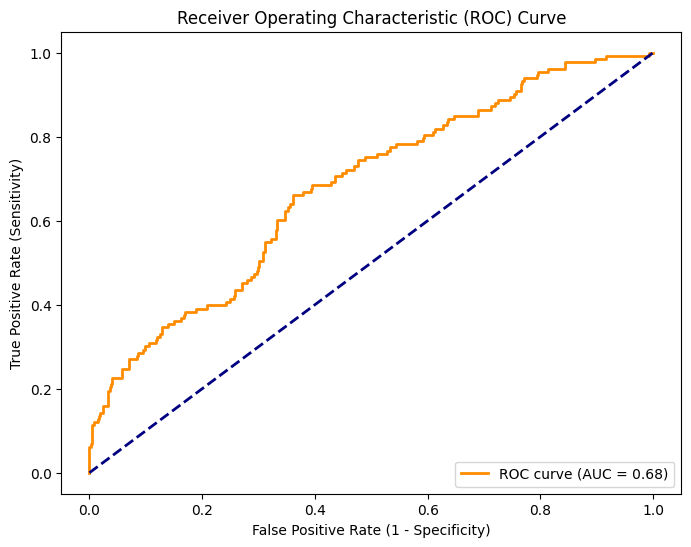

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

As another form of evaluation, we decided to create a ROC curve. This model compares True positive rate with false positive rate. The diagonal rate represents 50-50 chance. So, at very least, our model is better than random chance. The area under curve of our model is 0,68. So we can describe our model as moderate in discriminating between positive and negative instances.

In [15]:
print(result.summary())

                          Probit Regression Results                           
Dep. Variable:                   Draw   No. Observations:                 2203
Model:                         Probit   Df Residuals:                     2193
Method:                           MLE   Df Model:                            9
Date:                Sat, 20 Jan 2024   Pseudo R-squ.:                 0.08585
Time:                        16:16:04   Log-Likelihood:                -1137.7
converged:                       True   LL-Null:                       -1244.6
Covariance Type:            nonrobust   LLR p-value:                 4.455e-41
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1818      0.413     -0.440      0.660      -0.991       0.628
G1p           -0.2381      0.033     -7.248      0.000      -0.303      -0.174
G2p           -0.2613      0.031     -8.371      0.0

We can see that 6 of our independent variables are statistically significant with 5% significant level. However, our coeeficients are log likelihoods. So w firstly need to transform them, so we can interpret them on percentage wise.

In [16]:
coefficients = np.array([-0.1818, -0.2381, -0.2613, 0.0034, 0.0199, -0.0245, -0.0010, 0.0550, 0.0694, -0.0048])
coefficient_names = ['const', 'G1p', 'G2p', 'ÚT', 'S', 'SnB', 'P', 'ŽK', 'ČK', 'F']
p_values = np.array([0.660, 0.000, 0.000, 0.004, 0.005, 0.086, 0.015, 0.001, 0.307, 0.381])

percentage_change = (np.exp(coefficients) - 1) * 100

for name, coef, p_value in zip(coefficient_names, percentage_change, p_values):
    if p_value < 0.05:
        print(f'{name}: {coef:.2f}% (Statistically significant)')
    else:
        print(f'{name}: {coef:.2f}%')
        

const: -16.62%
G1p: -21.19% (Statistically significant)
G2p: -23.00% (Statistically significant)
ÚT: 0.34% (Statistically significant)
S: 2.01% (Statistically significant)
SnB: -2.42%
P: -0.10% (Statistically significant)
ŽK: 5.65% (Statistically significant)
ČK: 7.19%
F: -0.48%


3 of our significant variables are positive and 3 are negative. The biggest one in terms of precentage change are G1p and G2p. That is what we would expect. The probability of a match ending in draw should be lower with every goal scored. Goals scored in second half decrease the probability slightly more. This is probably the effect of a goal at the end of the game to which the other team does not have enough time to respond. Other than that, with 1 more pass in the match, the probability of draw decreases by 0,1%. 

On the other hand, all 3 variables with positive effects are quite suprising. We expected that both number of attacks and number of shots would decrease the probability of draw with higher numbers.But for every shot the probability of draw increases by 2,01% and for every attack the probability increases by 0,34%. Lastly, for every yellow card in the match, the probability of draw increases by 5,65%. 